In [ ]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [ ]:
# URL doesn't work directly with pd.read_csv for some reason..
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-09-02 20:02:05--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   699KB/s    in 0.7s    

2020-09-02 20:02:07 (699 KB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Strange ass format has produced some unnecessary columns..
# df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=0) # This isn't working for some reason..
del df["Unnamed: 2"]
del df["Unnamed: 3"]
del df["Unnamed: 4"]

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Rename the columns to something better..
df.columns = ["labels", "data"]

In [ ]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [ ]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [ ]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7192 unique tokens.


In [ ]:
# Pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# Get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [ ]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [ ]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 2s 19ms/step - loss: 0.4622 - accuracy: 0.8615 - val_loss: 0.3907 - val_accuracy: 0.8651
Epoch 2/10
117/117 [==============================] - 2s 14ms/step - loss: 0.3571 - accuracy: 0.8663 - val_loss: 0.3030 - val_accuracy: 0.8651
Epoch 3/10
117/117 [==============================] - 2s 14ms/step - loss: 0.2510 - accuracy: 0.8663 - val_loss: 0.2219 - val_accuracy: 0.8651
Epoch 4/10
117/117 [==============================] - 2s 14ms/step - loss: 0.1872 - accuracy: 0.8894 - val_loss: 0.1705 - val_accuracy: 0.9598
Epoch 5/10
117/117 [==============================] - 2s 14ms/step - loss: 0.1342 - accuracy: 0.9826 - val_loss: 0.1282 - val_accuracy: 0.9782
Epoch 6/10
117/117 [==============================] - 2s 14ms/step - loss: 0.0934 - accuracy: 0.9912 - val_loss: 0.0972 - val_accuracy: 0.9864
Epoch 7/10
117/117 [==============================] - 2s 14ms/step - loss: 0.0688 - accuracy: 0.9962 - val_loss: 0.0829 - va

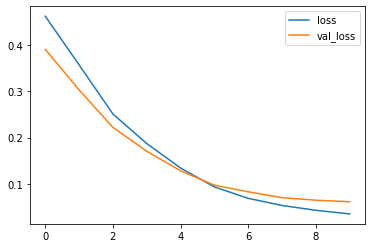

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

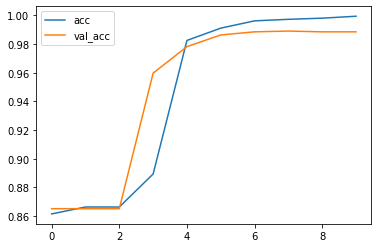

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()